# 아두이노

In [ ]:
#include <Wire.h>

const int MPU = 0x68;   //Default address of I2C for MPU 6050
int16_t AcX, AcY, AcZ,GyX,GyY,GyZ;

void setup() {
  Wire.begin();                   // Wire library initialization
  Wire.beginTransmission(MPU);    // Begin transmission to MPU
  Wire.write(0x6B);               // PWR_MGMT_1 register
  Wire.write(0);                  // MPU-6050 to start mode
  Wire.endTransmission(true);
  Serial.begin(9600);
}

void loop() {
  Wire.beginTransmission(MPU);      // Start transfer
  Wire.write(0x3B);                 // register 0x3B (ACCEL_XOUT_H), records data in queue
  Wire.endTransmission(false);      // Maintain connection
  Wire.requestFrom(MPU, 14, true);  // Request data to MPU
  //Reads byte by byte
  AcX = Wire.read() << 8 | Wire.read(); // 0x3B (ACCEL_XOUT_H) & 0x3C (ACCEL_XOUT_L)
  AcY = Wire.read() << 8 | Wire.read(); // 0x3D (ACCEL_YOUT_H) & 0x3E (ACCEL_YOUT_L)
  AcZ = Wire.read() << 8 | Wire.read(); // 0x3F (ACCEL_ZOUT_H) & 0x40 (ACCEL_ZOUT_L)
  GyX=Wire.read()<<8|Wire.read();
  GyY=Wire.read()<<8|Wire.read();
  GyZ=Wire.read()<<8|Wire.read();

  //Prints values on Serial
  Serial.print(AcX);
  Serial.print(","); 
  Serial.print(AcY);
  Serial.print(","); 
  Serial.println(AcZ);
  delay(100);
}

# Visual Studio Code

In [ ]:
import serial          
import numpy as np     
import matplotlib.pyplot as plt 

ser = serial.Serial('COM5',9600)   

In [ ]:
# Define Variables
Accx = []
Accy = []
Accz = []

len = 130

for i in range (len):               # Wait until the buffer is filled up to 50 values
    while (ser.inWaiting() == 0):   
        pass                        
        
    arduinoString = ser.readline().decode("utf-8") #.strip()
    
    dataArray = (arduinoString.split(','))      # Since the values are being sent consecutively, 
                                                # the values must be split into x,y,and z
    # Data conversion from string to float
    temp1 = float(dataArray[0])             
    temp2 = float(dataArray[1]) 
    temp3 = float(dataArray[2])
    
    # Convert second element to floating number and put in P
    Accx.append(temp1)                      
    Accy.append(temp2)                      
    Accz.append(temp3)

In [ ]:
print(Accx)
print(Accy)
print(Accz)

In [ ]:
plt.figure(1)
plt.subplot(311)                    # Set y min and max values
plt.title('Saved data')             # Plot the title
plt.grid(True)                      # Turn the grid on
plt.ylabel('Acceleration')          # Set ylabels
plt.plot(Accx, c='g', label='X')    # plot the temperature
plt.legend(loc='upper left')        # plot the legend
    
plt.subplot(312)                    # Set y min and max values
plt.grid(True)                      # Turn the grid on
plt.ylabel('Acceleration')          # Set ylabels
plt.plot(Accy,c='r', label='Y')    # plot the temperature
plt.legend(loc='upper left')          
    
plt.subplot(313)                    # Set y min and max values
plt.grid(True)                      # Turn the grid on
plt.ylabel('Acceleration')          # Set ylabels
plt.plot(Accz, c='b', label='Z')    # plot the temperature
plt.legend(loc='upper left')          

plt.show()

In [ ]:
ser.close()

In [ ]:
import pandas as pd
import openpyxl

zf = np.fft.fft(Accz)
zf = np.abs(zf)
print(zf)

dict_data = {'z': zf}
df = pd.DataFrame(dict_data, columns=["z"])
df = df.transpose()
print(df)

df.to_csv('DB.csv', mode='a', header=False, index=True)

In [ ]:
#엑셀 데이터 프레임으로 변환
import pandas as pd
import openpyxl
df = pd.read_csv('DB.csv', header = 0 ,index_col=0)
print(df)

In [ ]:
#scale
from sklearn.preprocessing import StandardScaler
df_scaled = StandardScaler().fit_transform(df.iloc[:,:-1])
print(df_scaled)

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2) # 주성분을 몇개로 할지 결정
printcipalComponents = pca.fit_transform(df_scaled)
principalDf = pd.DataFrame(data=printcipalComponents, columns = ['x', 'y'])
principalDf['target'] = df.target.values
# 주성분으로 이루어진 데이터 프레임 구성
principalDf.to_csv('DB_PCA.csv')

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import numpy as np

print(pca.explained_variance_ratio_)
rcf =RandomForestClassifier(random_state=156)
pca_x = principalDf[['x', 'y']]
score_pca = cross_val_score(rcf, pca_x, df.target, scoring='accuracy', cv =2)
print(score_pca)
print(np.mean(score_pca))

In [ ]:
from sklearn.model_selection import train_test_split
X = principalDf[['x', 'y']]
y = principalDf['target']
print(X)
print(np.unique(y))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)
print(len(X_train), "train +", len(X_test), "test")
print(X_train)
print(np.bincount(y))
print(np.bincount(y_train))

In [ ]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.2):
    # 마커와 컬러맵 설정하기
    markers=('s', 'x', 'o', '^', 'v')
    colors=('red','blue','lightgreen','gray','cyan')
    #cmap=ListedColormap(colors[:len(np.unique(y))])
    
    # 결정경계를 그리기
    x1_min, x1_max = X[:,0].min()-1, X[:,0].max()+1
    x2_min, x2_max = X[:,1].min()-1, X[:,1].max()+1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                          np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3) #cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y==cl,0], y=X[y==cl,1],
                   alpha=0.8, c=colors[idx],
                   marker=markers[idx], label=cl,
                   edgecolor='black')
        
    # 테스트 샘플을 부각하여 그리기
    if test_idx:
        X_test, y_test = X[test_idx, :], y[test_idx]
        plt.scatter(X_test[:,0], X_test[:,1],
                   c='', edgecolor='black',alpha=1.0,
                   linewidth=1, marker='o',
                   s=100, label='test set')
        


In [ ]:
from sklearn.svm import SVC
svm = SVC(kernel = 'linear', C = 1.0, random_state = 1)
svm.fit(X_train, y_train)
X_combined = np.vstack((X_train, X_test))
y_combined =np.hstack((y_train, y_test))
plot_decision_regions(X_combined,
                      y_combined,
                      classifier = svm,
                      test_idx = range(72, 103))
plt.xlabel('p')
plt.ylabel('v')
plt.tight_layout()
plt.show()
print("Accuracy(C=1): {}%".format(svm.score(X_test, y_test) * 100 ))

# colab

In [ ]:
import matplotlib.pyplot as plt 
markers = ['^', 's']
for i, marker in enumerate(markers):
    x_axis_data = principalDf[principalDf['target'] == i]['x']
    y_axis_data = principalDf[principalDf['target'] == i]['y']
    plt.scatter(x_axis_data, y_axis_data, marker=marker, label=i)

plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='upper left')
plt.show()

          0          1          2    ...        117        118        119
x  112.240000  27.694445  10.000017  ...  17.079008  10.000017  27.694445
y  120.266500   0.762586   0.379640  ...   0.917542   0.379640   0.762586
z  116.429714   0.172853   0.917193  ...   2.949638   0.917193   0.172853

[3 rows x 120 columns]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning 

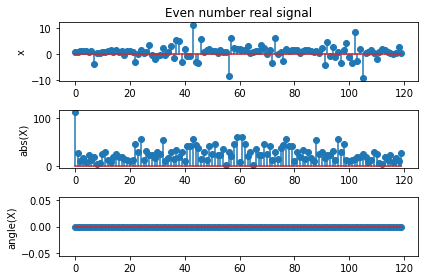

In [ ]:
#fft 코드
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

plt.ion()

x = np.array([1.03, 1.04, 1.14, 1.23, 1.36, 1.1, 1.34, -3.62, 0.6, 0.44, 0.96, 0.9, 1.27, 1.86, 1.0, 1.54, 0.86, 1.29, -0.4, 1.36, 1.15, 0.96, -2.84, 0.34, 1.57, 0.52, 1.06, 3.57, -0.39, -1.82, -0.77, -0.32, 2.38, -0.28, 0.81, 3.12, -1.4, 5.36, 5.14, -2.81, 1.99, -0.79, -0.43, 11.3, -3.12, -3.22, 6.03, 0.99, 1.55, 1.99, 1.36, 1.4, 0.63, 1.79, 0.94, 0.89, -8.49, 6.18, 2.6, 2.12, 1.9, 1.72, 1.77, 3.19, 0.69, 0.95, 1.28, 1.13, 3.81, 2.4, 0.12, 1.67, -3.24, 6.15, 0.32, 1.1, -2.68, 2.16, 1.5, 1.53, 1.83, 1.67, 0.36, 1.2, 1.83, 1.51, 1.14, 0.82, 1.47, 0.7, 2.46, -4.21, 4.79, -0.67, 2.79, -0.97, 1.0, -3.36, 1.8, 4.53, -0.83, -3.41, 8.56, -2.41, 1.95, -9.2, 0.4, 0.86, 1.56, 0.61, -1.74, 0.91, 2.16, 1.79, 0.89, 0.55, 0.12, 0.55, 2.94, 0.46]) # even number
y = np.array([1.0005, 0.998, 0.9985, 0.99475, 0.997, 0.9985, 1.00025, 1.00075, 1.0045, 1.0275, 1.00175, 1.008, 0.98, 0.95, 1.01475, 0.984, 1.01025, 1.012, 0.9835, 1.012, 1.00475, 0.9935, 1.14025, 1.0275, 1.007, 0.99275, 1.00275, 1.43925, 1.06425, 0.906, 0.927, 1.002, 1.029, 1.0615, 0.94275, 0.90925, 0.99975, 0.99475, 0.99375, 1.02625, 0.988, 0.9245, 0.822, 1.1725, 0.928, 1.00925, 0.89275, 0.954, 0.96375, 0.947, 1.06875, 0.985, 0.9515, 0.9915, 0.9965, 1.00175, 0.896, 1.23, 1.00425, 1.002, 1.0045, 0.9985, 1.064, 0.80975, 0.9875, 0.861, 0.88775, 1.00725, 1.16975, 1.03725, 1.02125, 1.3335, 0.80375, 0.97075, 0.99975, 1.0125, 0.8685, 1.00625, 0.9995, 1.001, 1.00025, 0.9295, 0.983, 0.924, 1.02025, 0.98175, 1.0675, 1.01775, 0.98375, 0.963, 0.9585, 1.03075, 0.98925, 0.99775, 1.0275, 1.16, 0.95925, 1.0185, 1.037, 0.99575, 0.9825, 0.7545, 1.33125, 1.03875, 0.873, 0.95225, 0.98425, 0.99925, 0.99925, 1.001, 1.1175, 0.934, 1.053, 1.01275, 0.9965, 1.00575, 1.008, 1.10475, 1.03, 1.02975])
z = np.array([-0.9622857142857143, -0.9554285714285714, -0.9977142857142857, -0.9531428571428572, -0.96, -0.9657142857142857, -0.9611428571428572, -0.8502857142857143, -1.0354285714285714, -1.0491428571428572, -0.9702857142857143, -0.9805714285714285, -0.8377142857142857, -0.46514285714285714, -1.8114285714285714, -0.8297142857142857, -1.0617142857142856, -0.9771428571428571, -1.0045714285714287, -1.0102857142857142, -0.9668571428571429, -0.9748571428571429, -1.5874285714285714, -0.8994285714285715, -1.0022857142857142, -0.936, -0.9622857142857143, -0.7371428571428571, -1.296, -1.008, -0.7074285714285714, -0.944, -0.9302857142857143, -1.6994285714285715, -0.8674285714285714, -0.27314285714285713, -0.9531428571428572, -0.8114285714285714, -0.8, -0.9485714285714286, -0.9234285714285714, -0.792, -1.3337142857142856, -0.384, -1.0262857142857142, -1.216, -0.9451428571428572, -0.472, -0.7897142857142857, -1.2937142857142858, -1.8571428571428572, -0.6811428571428572, -0.9725714285714285, -0.9302857142857143, -0.9554285714285714, -0.9565714285714285, -1.536, -0.4205714285714286, -0.9611428571428572, -0.9862857142857143, -0.9691428571428572, -1.056, -1.2742857142857142, -1.0102857142857142, -1.6125714285714285, -0.24342857142857144, -1.464, -0.7885714285714286, -0.06971428571428571, -1.1005714285714285, -0.8937142857142857, -1.4868571428571429, -1.0171428571428571, -1.008, -0.9371428571428572, -0.9131428571428571, -1.3382857142857143, -0.7657142857142857, -0.9074285714285715, -0.8971428571428571, -0.8491428571428571, -0.7851428571428571, -0.8457142857142858, -1.1554285714285715, -0.8491428571428571, -0.8571428571428571, -1.737142857142857, -1.4217142857142857, -1.0571428571428572, -0.21942857142857142, -1.0594285714285714, -0.5748571428571428, -0.776, -0.9234285714285714, -0.7988571428571428, -0.728, -1.0411428571428571, -1.1828571428571428, -0.8102857142857143, -0.7988571428571428, -0.7668571428571429, -1.665142857142857, -0.4308571428571429, -0.9302857142857143, -1.4217142857142857, -1.056, -1.0971428571428572, -0.9622857142857143, -1.0102857142857142, -1.0011428571428571, -1.046857142857143, -1.2262857142857142, -1.0834285714285714, -0.9771428571428571, -1.0194285714285714, -1.0194285714285714, -2.9371428571428573, 0.208, 0.2834285714285714, -0.6685714285714286])

xf = np.fft.fft(x)
yf = np.fft.fft(y)
zf = np.fft.fft(z)
xf = np.abs(xf)
yf = np.abs(yf)
zf = np.abs(zf)
dict_data = {'x': xf, 'y': yf, 'z': zf}
df = pd.DataFrame(dict_data)
df = df.transpose()
print(df)

plt.subplot(3,1,1)
plt.stem(x); plt.ylabel('x')
plt.title('Even number real signal')
# plt.title('Odd number real signal')

plt.subplot(3,1,2)
plt.stem(np.abs(xf)); plt.ylabel('abs(X)')

plt.subplot(3,1,3)
plt.stem(np.angle(xf)); plt.ylabel('angle(X)')

plt.tight_layout()

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2) # 주성분을 몇개로 할지 결정
printcipalComponents = pca.fit_transform(df)
principalDf = pd.DataFrame(data=printcipalComponents, columns = ['principal component1', 'principal component2'])
# 주성분으로 이루어진 데이터 프레임 구성
principalDf.head()

,principal component1,principal component2
0,191.691612,-1.262688
1,-109.547592,-12.617657
2,-82.144020,13.880345


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

x = np.array([5,7,8,7,2,17,2,9,4,11,12,9,6])
y = np.array([99,86,87,88,111,86,103,87,94,78,77,85,86])

plt.scatter(x, y, marker='^')
plt.show()

TypeError: ignored

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
filename = '/content/drive/MyDrive/Colab Notebooks/공부/DB_PCA.csv'

In [ ]:
import pandas as pd

df = pd.read_csv(filename)
df.head(100)

,Unnamed: 0,x,y,target
0,0,-9.808011,-0.527679,1
1,1,-8.623693,-0.266273,1
2,2,-5.569700,-1.940913,1
3,3,-8.554916,0.947765,1
4,4,-5.757722,0.408158,1
...,...,...,...,...
95,95,22.078973,-1.975974,1
96,96,31.330696,-3.505708,1
97,97,30.270754,-4.031085,1
98,98,-4.880131,-0.210286,1


In [ ]:
#scale
from sklearn.preprocessing import StandardScaler
df_scaled = StandardScaler().fit_transform(df.iloc[:,:-1])
print(df_scaled)

[[-1.72783143 -1.28773983 -0.18693961]
 [-1.71938238 -1.13224518 -0.0943317 ]
 [-1.71093333 -0.73127211 -0.6876022 ]
 ...
 [ 1.71093333 -0.62051072 -0.35559175]
 [ 1.71938238 -0.67100384 -0.58441081]
 [ 1.72783143 -0.72430173 -0.31158858]]


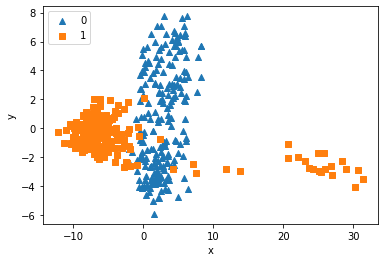

In [ ]:
markers = ['^', 's']
for i, marker in enumerate(markers):
    x_axis_data = df[df['target'] == i]['x']
    y_axis_data = df[df['target'] == i]['y']
    plt.scatter(x_axis_data, y_axis_data, marker=marker, label=i)
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='upper left')
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
X = df[['x', 'y']]
y = df['target']
print(x)
print(np.unique(y))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)
print(len(X_train), "train +", len(X_test), "test")
print(np.bincount(y))
print(np.bincount(y_train))

0     -9.080659
1     -7.720096
2     -4.785071
3     -7.707376
4     -4.429930
         ...   
98     5.466109
99     1.660628
100    6.702719
101    3.310669
102    2.087648
Name: x, Length: 103, dtype: float64
[0 1]
287 train + 123 test
[214 196]
[155 132]


In [ ]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.2):
    # 마커와 컬러맵 설정하기
    markers=('s', 'x', 'o', '^', 'v')
    colors=('red','blue','lightgreen','gray','cyan')
    cmap=ListedColormap(colors[:len(np.unique(y))])
    
    # 결정경계를 그리기
    x1_min, x1_max = X[:,0].min()-1, X[:,0].max()+1
    x2_min, x2_max = X[:,1].min()-1, X[:,1].max()+1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                          np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y==cl,0], y=X[y==cl,1],
                   alpha=0.8, c=colors[idx],
                   marker=markers[idx], label=cl,
                   edgecolor='black')
        
    # 테스트 샘플을 부각하여 그리기
    if test_idx:
        X_test, y_test = X[test_idx, :], y[test_idx]
        plt.scatter(X_test[:,0], X_test[:,1],
                   c='', edgecolor='black',alpha=1.0,
                   linewidth=1, marker='o',
                   s=100, label='test set')
        


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


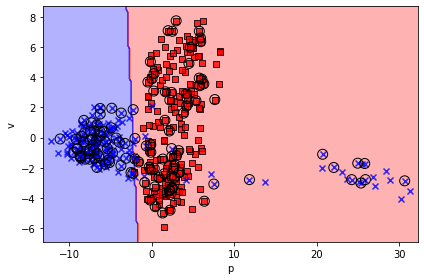

Accuracy(C=1): 88.6178861788618%


In [ ]:
from sklearn.svm import SVC
svm = SVC(kernel = 'linear', C = 1.0, random_state = 1)
svm.fit(X_train, y_train)
X_combined = np.vstack((X_train, X_test))
y_combined =np.hstack((y_train, y_test))
plot_decision_regions(X_combined,
                      y_combined,
                      classifier = svm,
                      test_idx = range(287, 410))
plt.xlabel('p')
plt.ylabel('v')
plt.tight_layout()
plt.show()
print("Accuracy(C=1): {}%".format(svm.score(X_test, y_test) * 100 ))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


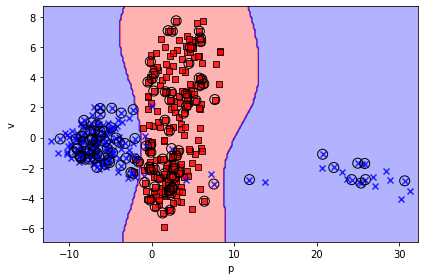

Accuracy(C=1): 95.9349593495935%


In [ ]:
from sklearn.svm import SVC
svm = SVC(kernel = 'rbf', C = 1.0, random_state = 1, gamma=0.1)
svm.fit(X_train, y_train)
X_combined = np.vstack((X_train, X_test))
y_combined =np.hstack((y_train, y_test))
plot_decision_regions(X_combined,
                      y_combined,
                      classifier = svm,
                      test_idx = range(287, 410))
plt.xlabel('p')
plt.ylabel('v')
plt.tight_layout()
plt.show()
print("Accuracy(C=1): {}%".format(svm.score(X_test, y_test) * 100 ))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


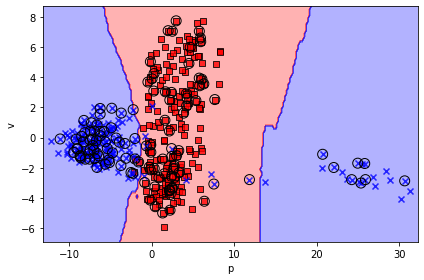

Accuracy(C=1): 95.1219512195122%


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 5, p = 2,
                           metric = 'minkowski')
knn.fit(X_train, y_train)
plot_decision_regions(X_combined, y_combined,
                      classifier=knn, test_idx = range(287, 410))
plt.xlabel('p')
plt.ylabel('v')
plt.tight_layout()
plt.show()
print("Accuracy(C=1): {}%".format(knn.score(X_test, y_test) * 100 ))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


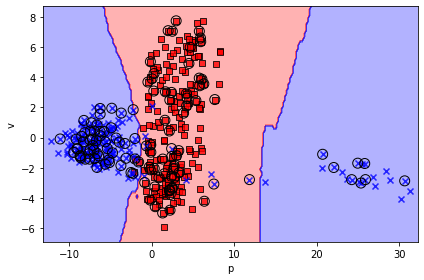

Accuracy(C=1): 96.7479674796748%


In [ ]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(criterion = 'gini',
                                 n_estimators = 25,
                                 random_state = 1,
                                 n_jobs=2)
forest.fit(X_train, y_train)
plot_decision_regions(X_combined, y_combined,
                      classifier=knn, test_idx = range(287, 410))
plt.xlabel('p')
plt.ylabel('v')
plt.tight_layout()
plt.show()
print("Accuracy(C=1): {}%".format(forest.score(X_test, y_test) * 100 ))
